In [1]:
from __future__ import division
import keras
import os
import sys
import time
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from tensorflow.python.keras import backend
from tensorflow.keras.models import load_model

from keras import optimizers
from keras import initializers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import GRU, RNN, LSTM, Reshape, SimpleRNN, Conv2D, MaxPooling2D, Permute, Flatten, Dense, BatchNormalization, Activation, Dropout

In [2]:
def slice_data(X, V, y, window_size, nr_epochs,step_size):

    sX = [X[:,i*step_size:i*step_size+window_size,:] for i in range(nr_epochs)]
    sV = [V[i*step_size,:] for i in range(nr_epochs)]
    
    sV = np.array(sV)
    sX = np.array(sX)
    sX = np.transpose(sX,(1,2,3,0))
    
    validation = np.zeros((y.shape[0],sV.shape[0]))
    for i in range(y.shape[0]):
        letter_index = y[i,0]-1
        validation[i,:] = sV[:,letter_index] 

    return sX, sV, validation

In [3]:
def transpose_reshape(X,y):
    x_channel, x_window, x_trial, x_epoch = X.shape
    
    X = X.transpose(2,3,1,0)
    X = X.reshape(x_epoch * x_trial, x_window, x_channel, 1)

    y.transpose(1,0)
    y = y.reshape(x_trial * x_epoch)
    
    return X, y

In [4]:
def one_hot_encode(y):
    # One-Hot encoding of a flat validation array
    hot_vector = np.zeros((y.shape[0],2))
    for i in range(y.shape[0]):
        if y[i] == 1:
            hot_vector[i,1] = 1
        else:
            hot_vector[i,0] = 1
            
    return hot_vector   

In [5]:
def load_donders_matfile(par = 1):
    

    
    
    data = loadmat('Data/xsub-{:02d}/xsub-{:02d}_gdf.mat'.format(par,par))
    X = data['X']           # EEG data: channels x samples x trials
    V = data['V']           # Codes: bits x codes
    y = data['y']           # Labels: 1 x trials
    
    
    channels = ['Fpz','T7', 'O1', 'POz', 'Oz', 'Iz', 'O2', 'T8']

    print('X: ',X.shape)
    print('V: ',V.shape)
    print('y: ',y.shape)

    n_channels, n_samples, n_trials = X.shape   # Extracting data dimensions
    step_size = 2                               # from 8ms per sample to 16 ms per sample fs/fr
    window_size = 30                            # Number of samples from 120 hz sampling frequency and having 250 ms window.
    nr_epochs = int(n_samples-(n_samples/step_size)-window_size)

    
    # Extend the code to the length of the full trial.
    V_ext = np.tile(V,(15,1))

    sX, sV, validation = slice_data(X,V_ext,y,window_size,nr_epochs,step_size)

    
    
    # Train-test split parameter
    split = int((80/100)*n_trials)
    test_split = int((90/100)*n_trials)
    
    
    sXtrain = sX[:,:,:split,:]
    sXval   = sX[:,:,split:test_split,:] 
    sXtest  = sX[:,:,test_split:,:]
    
    sYtrain = validation[:split,:]
    sYval   = validation[split:test_split,:]
    sYtest  = validation[test_split:,:]
     
    t_train = sXtrain.shape[2]
    e_train = sXtrain.shape[3]
    
    # Transpose and Reshape sXtrain and sXval from (channels x windowSize x trials x epochs) 
    # to (samples x windowSize x channels x 1) such that it fits the NHWC format
    
    sXtrain, sYtrain = transpose_reshape(sXtrain,sYtrain)
    sXval, sYval = transpose_reshape(sXval, sYval)
    sXtest, sYtest = transpose_reshape(sXtest, sYtest)
    
    
    
    
    sYtrain = one_hot_encode(sYtrain)
    sYval = one_hot_encode(sYval)
    sYtest = one_hot_encode(sYtest)
    




    return sXtrain, sYtrain, sXval, sYval, sXtest, sYtest, sV, X, y

In [6]:
## CREATE EEG2Code CNN Model
def construct_model(windowSize,numberChannels, batch_size):
    model = Sequential()
    model.add(Permute((2,1,3), batch_input_shape=(batch_size, windowSize,numberChannels,1)))
    
    # layer1
    model.add(Conv2D(16, kernel_size=(numberChannels, 1), padding='valid', 
                     strides=(1, 1), data_format='channels_last', activation='relu'))
    model.add(BatchNormalization(axis=3, scale=False, center=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 2),strides=(1, 1),padding='same')) 
    
    # layer2
    model.add(Conv2D(8,kernel_size=(1, 12),data_format='channels_last',padding='valid')) #OG = 8, kernel size =(1,64)
    model.add(BatchNormalization(axis=3,scale=False, center=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 2),strides=(1, 1),padding='same'))
#     model.add(Dropout(0.5))

    # layer3
    model.add(Conv2D(4,kernel_size=(1,5) ,data_format='channels_last',padding='same')) # ks = (1,5) instead of (5,5) because
    model.add(BatchNormalization(axis=3,scale=False,center=False))                      # our channels are not spatially ordered to be next to each other
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 2) , data_format='channels_last',padding='same'))
#     model.add(Dropout(0.5))
    
    # layer4
    model.add(Reshape((1,-1), batch_input_shape=(batch_size,1,-1)))
    model.add((SimpleRNN(20)))

    model.add(Dense(256, activation='relu')) #OG = 1024
    model.add(Dropout(0.5))
    
    # layer5
    model.add(Dense(2, activation='softmax'))
    
    return model

In [7]:
def split_k_folds(k_folds, sX, y, validation):
    n_trials = sX.shape[2]
    folds = np.repeat(np.arange(k_folds), n_trials / k_folds)
    
    list_fXtrain = []
    list_fXtest = []
    
    list_fYtrain = []
    list_fYtest = []
    
    list_labels = []
    

    for i_fold in range(k_folds):
        # Split into train and test sets
        X_train = sX[:, :, folds!=i_fold,:]
        X_test = sX[:, :, folds == i_fold,:]
        y_train = validation[folds!=i_fold,:]
        y_test = validation[folds == i_fold,:]
        
        test_labels = y[folds == i_fold,:]
        
        
        # Reshape all sets to the NHWC format (samples x windowSize x channels x 1) for the network
        fXtrain, fYtrain = transpose_reshape(X_train, y_train)  
        fXtest, fYtest = transpose_reshape(X_test, y_test)
        
        
        # One-hot encode every y for the network
        fYtrain = one_hot_encode(fYtrain)
        fYtest = one_hot_encode(fYtest)
        
        
        # Add every fold set to their corresponding list
        list_fXtrain.append(fXtrain)
        list_fXtest.append(fXtest)

        list_fYtrain.append(fYtrain)
        list_fYtest.append(fYtest)
        
        list_labels.append(test_labels)
        
    return list_fXtrain, list_fXtest, list_fYtrain, list_fYtest, list_labels

In [8]:
def rnn_fit(train_dataset, val_dataset, batch_size=1860, iterations=1, lr = 0.003):
    
    window_size = 30
    channels = 8
    
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

    
    
    model = construct_model(data_x_train.shape[1], data_x_train.shape[2], batch_size)
    history = []
    accuracy = []
    loss = []
    val_accuracy = []
    val_loss = []
    
    for iteration in range(iterations):
        print("\nStart of iteration {:d}".format(iteration))
        start_time = time.time()
        

        # Iterate over the batches of the dataset. 
        # Assume batch size = length of trial
        for batch, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            batch_time = time.time()
            
            
            # Iterate over epochs within the trial
            multi_epoch_loss = 0
            trial_length = x_batch_train.shape[0]
            for i in range(0, trial_length):                
                x = tf.slice(x_batch_train, begin=[i,0,0,0], size=[1,window_size,channels,1])
                y = tf.slice(y_batch_train, begin=[i], size=[1])

                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)               
                    loss_value = loss_fn(y_batch_train, logits)


                    multi_epoch_loss += loss_value

                    # Learn from loss every 62 epochs
                    if i%10 == 0:
                        grads = tape.gradient(multi_epoch_loss, model.trainable_weights)
                        optimizer.apply_gradients(zip(grads, model.trainable_weights))
                        multi_epoch_loss = 0  # Reset loss per 62 epochs

                        # Update training metric.
                        train_acc_metric.update_state(y_batch_train, logits)
#                         print(i, float(train_acc_metric.result()))

 
            print('Step: {:d}, {:.2f}s  -  loss: {:4f}  -  accuracy: {:4f}'.format(batch + 1, time.time()-batch_time, loss_value, train_acc_metric.result())  )
            
#             print("Training loss (for final epoch) at batch {:d}: {:4f}".format(batch, float(loss_value)))
#             print("Training accuracy (for final epoch) at batch {:d}: {:4f}".format(batch, float(train_acc_metric.result())))
#             print("Time per batch: {:.2f} \nSeen so far: {:d} samples\n".format((time.time()-batch_time),, ))

        # Display metrics at the end of each iteration.
        loss.append(float(loss_value))
        train_acc = train_acc_metric.result()
        accuracy.append(float(train_acc))
        print("Training acc over iteration: {:4f}".format(float(train_acc)))

        # Reset training metrics at the end of each iteration
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each iteration to test average performance
        steps = 0
        v_loss = 0
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            v_loss += loss_fn(y_batch_val, val_logits)
            steps += 1
            
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
            
        val_loss.append(float(v_loss/steps))
        
        val_acc = val_acc_metric.result()
        val_accuracy.append(float(val_acc))
        val_acc_metric.reset_states()
        
        
        print("\nValidation loss: {:4f}".format(float(v_loss)))
        print("Validation acc: {:4f}".format(float(val_acc)))
        print("Time taken: {:.2f}".format(time.time() - start_time))
    
    history.append(accuracy)
    history.append(val_accuracy)
    history.append(loss)
    history.append(val_loss)
    return (model, history)
        


## Run data collection

In [9]:
amount_participants = 5
iterations = 5
lr = 0.003


histories_participants = []

five_par_time = time.time()
for participant in range(1,amount_participants+1):
    print('Loading participant: {:d}'.format(participant))

    ## LOAD data
    (data_x_train,data_y_train,data_x_val,data_y_val,data_x_test,data_y_test, sV, X, y) = load_donders_matfile(participant)

    
    # Reduce data to 1/3 of original length. Around 10 seconds
    reduction = 1/3
    samples = sV.shape[0]
    batch_size = int(samples*reduction)
    
    
    train_x = data_x_train
    train_y = data_y_train
    val_x = data_x_val
    val_y = data_y_val

    for trial in range(80, 0, -1):
        begin = int(samples*reduction) + samples * (trial-1) 
        end = samples * trial


        train_x = np.delete(train_x, np.s_[begin:end],axis=0)
        train_y = np.delete(train_y, np.s_[begin:end],axis=0)

        val_x = np.delete(val_x, np.s_[begin:end],axis=0)
        val_y = np.delete(val_y, np.s_[begin:end],axis=0)
    

    
    
    # Split the data into batches
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y[:,1]))
    train_dataset = train_dataset.batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y[:,1]))
    val_dataset = val_dataset.batch(batch_size)
    
    
    model, history = rnn_fit(train_dataset, val_dataset, samples, iterations, lr)
               
            
    histories_participants.append(history)
    
    
    MODEL_FILE = 'RNN_trained_par_{:d}.hdf5'.format(participant)
    model.save(MODEL_FILE)
print('5 participants trained in: ', time.time()-five_par_time)

Loading participant: 1
X:  (8, 3780, 100)
V:  (252, 20)
y:  (100, 1)

Start of iteration 0
Step: 1, 16.06s  -  loss: 0.345122  -  accuracy: 0.862643
Step: 2, 15.49s  -  loss: 0.407305  -  accuracy: 0.838293
Step: 3, 15.47s  -  loss: 0.436153  -  accuracy: 0.834036
Step: 4, 15.44s  -  loss: 0.441081  -  accuracy: 0.825033
Step: 5, 15.59s  -  loss: 0.439015  -  accuracy: 0.824199
Step: 6, 15.93s  -  loss: 0.415073  -  accuracy: 0.828859
Step: 7, 15.90s  -  loss: 0.460273  -  accuracy: 0.821770
Step: 8, 16.42s  -  loss: 0.438434  -  accuracy: 0.823117
Step: 9, 16.47s  -  loss: 0.370207  -  accuracy: 0.826928
Step: 10, 16.37s  -  loss: 0.426472  -  accuracy: 0.827190
Step: 11, 16.52s  -  loss: 0.458633  -  accuracy: 0.825116
Step: 12, 16.71s  -  loss: 0.416764  -  accuracy: 0.827387
Step: 13, 17.13s  -  loss: 0.405503  -  accuracy: 0.829543
Step: 14, 16.51s  -  loss: 0.477213  -  accuracy: 0.825052
Step: 15, 16.60s  -  loss: 0.397726  -  accuracy: 0.826419
Step: 16, 15.90s  -  loss: 0.4442

Step: 57, 17.25s  -  loss: 0.538851  -  accuracy: 0.806196
Step: 58, 17.38s  -  loss: 0.468843  -  accuracy: 0.806288
Step: 59, 17.43s  -  loss: 0.569971  -  accuracy: 0.804543
Step: 60, 17.26s  -  loss: 0.442495  -  accuracy: 0.804847
Step: 61, 17.30s  -  loss: 0.484899  -  accuracy: 0.804750
Step: 62, 17.17s  -  loss: 0.478192  -  accuracy: 0.804548
Step: 63, 17.53s  -  loss: 0.466465  -  accuracy: 0.804358
Step: 64, 17.11s  -  loss: 0.480100  -  accuracy: 0.803860
Step: 65, 17.50s  -  loss: 0.424824  -  accuracy: 0.803728
Step: 66, 17.10s  -  loss: 0.429957  -  accuracy: 0.804342
Step: 67, 17.21s  -  loss: 0.631480  -  accuracy: 0.801709
Step: 68, 17.35s  -  loss: 0.473225  -  accuracy: 0.801495
Step: 69, 17.68s  -  loss: 0.463887  -  accuracy: 0.801477
Step: 70, 17.25s  -  loss: 0.473333  -  accuracy: 0.801618
Step: 71, 17.24s  -  loss: 0.497379  -  accuracy: 0.801106
Step: 72, 17.20s  -  loss: 0.394823  -  accuracy: 0.801736
Step: 73, 17.14s  -  loss: 0.483013  -  accuracy: 0.8016

Step: 32, 16.22s  -  loss: 0.499706  -  accuracy: 0.807725
Step: 33, 16.24s  -  loss: 0.481683  -  accuracy: 0.807494
Step: 34, 16.18s  -  loss: 0.398965  -  accuracy: 0.808901
Step: 35, 16.24s  -  loss: 0.503347  -  accuracy: 0.807490
Step: 36, 17.31s  -  loss: 0.460955  -  accuracy: 0.808128
Step: 37, 17.74s  -  loss: 0.487672  -  accuracy: 0.807929
Step: 38, 17.31s  -  loss: 0.429420  -  accuracy: 0.809415
Step: 39, 17.50s  -  loss: 0.453690  -  accuracy: 0.810281
Step: 40, 17.56s  -  loss: 0.437928  -  accuracy: 0.810809
Step: 41, 17.33s  -  loss: 0.560731  -  accuracy: 0.808689
Step: 42, 17.40s  -  loss: 0.471318  -  accuracy: 0.808993
Step: 43, 17.25s  -  loss: 0.419239  -  accuracy: 0.810540
Step: 44, 17.71s  -  loss: 0.511611  -  accuracy: 0.809700
Step: 45, 17.23s  -  loss: 0.531324  -  accuracy: 0.808558
Step: 46, 17.22s  -  loss: 0.447020  -  accuracy: 0.809120
Step: 47, 17.22s  -  loss: 0.443884  -  accuracy: 0.809358
Step: 48, 17.27s  -  loss: 0.424764  -  accuracy: 0.8106

Step: 6, 16.09s  -  loss: 0.558869  -  accuracy: 0.765648
Step: 7, 16.04s  -  loss: 0.537991  -  accuracy: 0.756931
Step: 8, 16.04s  -  loss: 0.539492  -  accuracy: 0.750719
Step: 9, 16.08s  -  loss: 0.620335  -  accuracy: 0.737984
Step: 10, 16.96s  -  loss: 0.623038  -  accuracy: 0.728270
Step: 11, 16.16s  -  loss: 0.580306  -  accuracy: 0.721765
Step: 12, 16.13s  -  loss: 0.577139  -  accuracy: 0.717699
Step: 13, 16.11s  -  loss: 0.578658  -  accuracy: 0.713494
Step: 14, 16.08s  -  loss: 0.600977  -  accuracy: 0.708605
Step: 15, 16.15s  -  loss: 0.637533  -  accuracy: 0.702600
Step: 16, 16.12s  -  loss: 0.638811  -  accuracy: 0.698483
Step: 17, 16.19s  -  loss: 0.636289  -  accuracy: 0.692889
Step: 18, 16.59s  -  loss: 0.597326  -  accuracy: 0.691554
Step: 19, 16.38s  -  loss: 0.653812  -  accuracy: 0.687907
Step: 20, 18.40s  -  loss: 0.643804  -  accuracy: 0.684758
Step: 21, 16.54s  -  loss: 0.647241  -  accuracy: 0.681697
Step: 22, 16.42s  -  loss: 0.608927  -  accuracy: 0.680618
S

Step: 63, 16.63s  -  loss: 0.684756  -  accuracy: 0.586525
Step: 64, 16.14s  -  loss: 0.703112  -  accuracy: 0.586559
Step: 65, 16.15s  -  loss: 0.645533  -  accuracy: 0.587495
Step: 66, 16.10s  -  loss: 0.720495  -  accuracy: 0.587291
Step: 67, 16.13s  -  loss: 0.695999  -  accuracy: 0.587382
Step: 68, 16.12s  -  loss: 0.714875  -  accuracy: 0.587401
Step: 69, 16.13s  -  loss: 0.679467  -  accuracy: 0.587530
Step: 70, 17.24s  -  loss: 0.671353  -  accuracy: 0.587935
Step: 71, 16.17s  -  loss: 0.677820  -  accuracy: 0.588322
Step: 72, 16.16s  -  loss: 0.694315  -  accuracy: 0.588355
Step: 73, 16.08s  -  loss: 0.690018  -  accuracy: 0.588550
Step: 74, 16.19s  -  loss: 0.734273  -  accuracy: 0.588191
Step: 75, 16.29s  -  loss: 0.695455  -  accuracy: 0.588160
Step: 76, 16.12s  -  loss: 0.726942  -  accuracy: 0.587874
Step: 77, 16.51s  -  loss: 0.710887  -  accuracy: 0.587804
Step: 78, 16.24s  -  loss: 0.663407  -  accuracy: 0.588359
Step: 79, 16.13s  -  loss: 0.700404  -  accuracy: 0.5883

Step: 38, 15.94s  -  loss: 0.756810  -  accuracy: 0.577119
Step: 39, 16.27s  -  loss: 0.771341  -  accuracy: 0.575999
Step: 40, 16.03s  -  loss: 0.711642  -  accuracy: 0.576442
Step: 41, 15.97s  -  loss: 0.745479  -  accuracy: 0.575898
Step: 42, 15.98s  -  loss: 0.661646  -  accuracy: 0.577217
Step: 43, 16.09s  -  loss: 0.729374  -  accuracy: 0.577060
Step: 44, 16.90s  -  loss: 0.728647  -  accuracy: 0.576887
Step: 45, 16.03s  -  loss: 0.705999  -  accuracy: 0.577046
Step: 46, 15.96s  -  loss: 0.755199  -  accuracy: 0.576391
Step: 47, 15.93s  -  loss: 0.751972  -  accuracy: 0.575814
Step: 48, 16.28s  -  loss: 0.753602  -  accuracy: 0.575258
Step: 49, 16.83s  -  loss: 0.661602  -  accuracy: 0.576109
Step: 50, 18.65s  -  loss: 0.778658  -  accuracy: 0.575013
Step: 51, 19.50s  -  loss: 0.729578  -  accuracy: 0.574659
Step: 52, 17.24s  -  loss: 0.694985  -  accuracy: 0.575198
Step: 53, 16.10s  -  loss: 0.747638  -  accuracy: 0.574644
Step: 54, 16.04s  -  loss: 0.701975  -  accuracy: 0.5749

Step: 12, 16.47s  -  loss: 0.556830  -  accuracy: 0.761514
Step: 13, 16.19s  -  loss: 0.523020  -  accuracy: 0.759193
Step: 14, 16.13s  -  loss: 0.557041  -  accuracy: 0.754986
Step: 15, 16.21s  -  loss: 0.563428  -  accuracy: 0.751280
Step: 16, 16.67s  -  loss: 0.555710  -  accuracy: 0.747740
Step: 17, 16.22s  -  loss: 0.564869  -  accuracy: 0.743551
Step: 18, 16.15s  -  loss: 0.524632  -  accuracy: 0.743634
Step: 19, 16.23s  -  loss: 0.548968  -  accuracy: 0.742684
Step: 20, 16.20s  -  loss: 0.605174  -  accuracy: 0.737799
Step: 21, 16.33s  -  loss: 0.548697  -  accuracy: 0.736941
Step: 22, 16.21s  -  loss: 0.550186  -  accuracy: 0.735790
Step: 23, 16.24s  -  loss: 0.533509  -  accuracy: 0.735236
Step: 24, 16.57s  -  loss: 0.553683  -  accuracy: 0.734210
Step: 25, 16.24s  -  loss: 0.494244  -  accuracy: 0.734650
Step: 26, 16.32s  -  loss: 0.539230  -  accuracy: 0.734234
Step: 27, 16.22s  -  loss: 0.565040  -  accuracy: 0.732922
Step: 28, 16.27s  -  loss: 0.532211  -  accuracy: 0.7330

Step: 69, 16.55s  -  loss: 0.574635  -  accuracy: 0.696975
Step: 70, 16.13s  -  loss: 0.639072  -  accuracy: 0.696429
Step: 71, 16.08s  -  loss: 0.648763  -  accuracy: 0.695888
Step: 72, 16.04s  -  loss: 0.576165  -  accuracy: 0.696151
Step: 73, 16.01s  -  loss: 0.651971  -  accuracy: 0.695404
Step: 74, 16.05s  -  loss: 0.576221  -  accuracy: 0.695582
Step: 75, 16.11s  -  loss: 0.600607  -  accuracy: 0.695667
Step: 76, 16.58s  -  loss: 0.559993  -  accuracy: 0.696094
Step: 77, 16.07s  -  loss: 0.635987  -  accuracy: 0.695646
Step: 78, 16.15s  -  loss: 0.600331  -  accuracy: 0.695648
Step: 79, 16.27s  -  loss: 0.572940  -  accuracy: 0.696018
Step: 80, 16.19s  -  loss: 0.617876  -  accuracy: 0.695743
Training acc over iteration: 0.695743

Validation loss: 6.620978
Validation acc: 0.650968
Time taken: 1300.03

Start of iteration 2
Step: 1, 16.19s  -  loss: 0.648361  -  accuracy: 0.645682
Step: 2, 16.07s  -  loss: 0.537455  -  accuracy: 0.699311
Step: 3, 16.23s  -  loss: 0.635000  -  accur

Step: 44, 18.12s  -  loss: 0.637960  -  accuracy: 0.683773
Step: 45, 16.50s  -  loss: 0.565512  -  accuracy: 0.684737
Step: 46, 15.98s  -  loss: 0.592388  -  accuracy: 0.685050
Step: 47, 16.09s  -  loss: 0.624552  -  accuracy: 0.684703
Step: 48, 16.10s  -  loss: 0.622935  -  accuracy: 0.684351
Step: 49, 16.59s  -  loss: 0.582617  -  accuracy: 0.685035
Step: 50, 15.97s  -  loss: 0.619750  -  accuracy: 0.684932
Step: 51, 16.20s  -  loss: 0.631156  -  accuracy: 0.684527
Step: 52, 15.91s  -  loss: 0.580979  -  accuracy: 0.685015
Step: 53, 16.02s  -  loss: 0.693907  -  accuracy: 0.683555
Step: 54, 15.93s  -  loss: 0.609334  -  accuracy: 0.683677
Step: 55, 16.73s  -  loss: 0.611002  -  accuracy: 0.683644
Step: 56, 15.93s  -  loss: 0.584381  -  accuracy: 0.684232
Step: 57, 16.57s  -  loss: 0.626165  -  accuracy: 0.683937
Step: 58, 16.09s  -  loss: 0.669422  -  accuracy: 0.683011
Step: 59, 16.05s  -  loss: 0.561651  -  accuracy: 0.684011
Step: 60, 15.97s  -  loss: 0.682617  -  accuracy: 0.6829

Step: 18, 15.93s  -  loss: 0.530705  -  accuracy: 0.732443
Step: 19, 15.94s  -  loss: 0.562427  -  accuracy: 0.731819
Step: 20, 15.99s  -  loss: 0.581638  -  accuracy: 0.729939
Step: 21, 15.96s  -  loss: 0.512082  -  accuracy: 0.730155
Step: 22, 16.47s  -  loss: 0.598779  -  accuracy: 0.728420
Step: 23, 16.00s  -  loss: 0.569798  -  accuracy: 0.727925
Step: 24, 16.05s  -  loss: 0.623799  -  accuracy: 0.724843
Step: 25, 15.96s  -  loss: 0.620930  -  accuracy: 0.722132
Step: 26, 15.94s  -  loss: 0.562989  -  accuracy: 0.721442
Step: 27, 16.04s  -  loss: 0.600716  -  accuracy: 0.719857
Step: 28, 16.01s  -  loss: 0.619126  -  accuracy: 0.717573
Step: 29, 16.00s  -  loss: 0.618116  -  accuracy: 0.715977
Step: 30, 16.49s  -  loss: 0.602135  -  accuracy: 0.714246
Step: 31, 15.99s  -  loss: 0.553513  -  accuracy: 0.714504
Step: 32, 16.12s  -  loss: 0.589082  -  accuracy: 0.714047
Step: 33, 15.93s  -  loss: 0.584562  -  accuracy: 0.713069
Step: 34, 16.01s  -  loss: 0.605155  -  accuracy: 0.7115

Step: 75, 16.41s  -  loss: 0.723543  -  accuracy: 0.653798
Step: 76, 16.47s  -  loss: 0.660689  -  accuracy: 0.653385
Step: 77, 15.99s  -  loss: 0.641814  -  accuracy: 0.653055
Step: 78, 15.98s  -  loss: 0.614650  -  accuracy: 0.653389
Step: 79, 15.97s  -  loss: 0.664866  -  accuracy: 0.653136
Step: 80, 15.91s  -  loss: 0.611682  -  accuracy: 0.653395
Training acc over iteration: 0.653395

Validation loss: 7.305480
Validation acc: 0.581129
Time taken: 1292.47

Start of iteration 2
Step: 1, 16.01s  -  loss: 0.603634  -  accuracy: 0.693809
Step: 2, 16.05s  -  loss: 0.622436  -  accuracy: 0.683052
Step: 3, 16.36s  -  loss: 0.690524  -  accuracy: 0.656946
Step: 4, 16.47s  -  loss: 0.621757  -  accuracy: 0.655600
Step: 5, 15.99s  -  loss: 0.574573  -  accuracy: 0.667305
Step: 6, 16.06s  -  loss: 0.566946  -  accuracy: 0.675884
Step: 7, 15.95s  -  loss: 0.601942  -  accuracy: 0.678289
Step: 8, 15.95s  -  loss: 0.600362  -  accuracy: 0.681237
Step: 9, 15.99s  -  loss: 0.601972  -  accuracy: 0

Step: 50, 16.11s  -  loss: 0.639068  -  accuracy: 0.649919
Step: 51, 16.17s  -  loss: 0.634475  -  accuracy: 0.649826
Step: 52, 15.90s  -  loss: 0.635185  -  accuracy: 0.649906
Step: 53, 16.11s  -  loss: 0.661649  -  accuracy: 0.649235
Step: 54, 16.17s  -  loss: 0.621956  -  accuracy: 0.649592
Step: 55, 15.93s  -  loss: 0.666572  -  accuracy: 0.649492
Step: 56, 15.97s  -  loss: 0.661642  -  accuracy: 0.649318
Step: 57, 15.95s  -  loss: 0.717260  -  accuracy: 0.648086
Step: 58, 16.49s  -  loss: 0.639798  -  accuracy: 0.648154
Step: 59, 15.94s  -  loss: 0.648781  -  accuracy: 0.647937
Step: 60, 15.96s  -  loss: 0.780602  -  accuracy: 0.645261
Step: 61, 16.06s  -  loss: 0.663264  -  accuracy: 0.645014
Step: 62, 15.93s  -  loss: 0.698004  -  accuracy: 0.644299
Step: 63, 15.95s  -  loss: 0.751972  -  accuracy: 0.642648
Step: 64, 16.03s  -  loss: 0.688517  -  accuracy: 0.641905
Step: 65, 16.39s  -  loss: 0.647151  -  accuracy: 0.642136
Step: 66, 15.98s  -  loss: 0.631540  -  accuracy: 0.6423

Step: 24, 17.17s  -  loss: 0.626131  -  accuracy: 0.728780
Step: 25, 16.36s  -  loss: 0.577366  -  accuracy: 0.726745
Step: 26, 16.24s  -  loss: 0.582951  -  accuracy: 0.724893
Step: 27, 16.18s  -  loss: 0.624132  -  accuracy: 0.722022
Step: 28, 16.16s  -  loss: 0.625387  -  accuracy: 0.718895
Step: 29, 16.15s  -  loss: 0.603910  -  accuracy: 0.716901
Step: 30, 16.16s  -  loss: 0.602477  -  accuracy: 0.714767
Step: 31, 16.70s  -  loss: 0.616973  -  accuracy: 0.713130
Step: 32, 16.19s  -  loss: 0.610056  -  accuracy: 0.711609
Step: 33, 16.21s  -  loss: 0.587637  -  accuracy: 0.710907
Step: 34, 16.32s  -  loss: 0.612090  -  accuracy: 0.709547
Step: 35, 15.95s  -  loss: 0.642328  -  accuracy: 0.707785
Step: 36, 15.96s  -  loss: 0.601965  -  accuracy: 0.706879
Step: 37, 15.97s  -  loss: 0.613437  -  accuracy: 0.705691
Step: 38, 16.45s  -  loss: 0.633250  -  accuracy: 0.703468
Step: 39, 15.97s  -  loss: 0.590185  -  accuracy: 0.702868
Step: 40, 15.98s  -  loss: 0.600624  -  accuracy: 0.7020

Step: 1, 16.24s  -  loss: 0.640200  -  accuracy: 0.644771
Step: 2, 15.99s  -  loss: 0.642459  -  accuracy: 0.649831
Step: 3, 16.13s  -  loss: 0.626591  -  accuracy: 0.651717
Step: 4, 16.53s  -  loss: 0.622981  -  accuracy: 0.656269
Step: 5, 16.50s  -  loss: 0.612307  -  accuracy: 0.657404
Step: 6, 16.01s  -  loss: 0.676172  -  accuracy: 0.650221
Step: 7, 16.06s  -  loss: 0.637659  -  accuracy: 0.650561
Step: 8, 16.01s  -  loss: 0.640679  -  accuracy: 0.650042
Step: 9, 15.91s  -  loss: 0.643289  -  accuracy: 0.650306
Step: 10, 16.00s  -  loss: 0.658423  -  accuracy: 0.648855
Step: 11, 16.03s  -  loss: 0.643906  -  accuracy: 0.649615
Step: 12, 16.69s  -  loss: 0.593874  -  accuracy: 0.654511
Step: 13, 16.03s  -  loss: 0.627895  -  accuracy: 0.654627
Step: 14, 16.01s  -  loss: 0.640678  -  accuracy: 0.655030
Step: 15, 16.02s  -  loss: 0.586868  -  accuracy: 0.657915
Step: 16, 16.00s  -  loss: 0.685842  -  accuracy: 0.655426
Step: 17, 16.02s  -  loss: 0.660002  -  accuracy: 0.654081
Step: 

Step: 58, 15.96s  -  loss: 0.706776  -  accuracy: 0.630281
Step: 59, 16.45s  -  loss: 0.629398  -  accuracy: 0.631021
Step: 60, 16.10s  -  loss: 0.714883  -  accuracy: 0.630195
Step: 61, 16.16s  -  loss: 0.790417  -  accuracy: 0.628348
Step: 62, 16.63s  -  loss: 0.743907  -  accuracy: 0.627246
Step: 63, 15.97s  -  loss: 0.664875  -  accuracy: 0.627366
Step: 64, 16.03s  -  loss: 0.716558  -  accuracy: 0.626584
Step: 65, 16.04s  -  loss: 0.718060  -  accuracy: 0.625898
Step: 66, 16.52s  -  loss: 0.695520  -  accuracy: 0.625573
Step: 67, 15.95s  -  loss: 0.695004  -  accuracy: 0.625279
Step: 68, 16.02s  -  loss: 0.648286  -  accuracy: 0.625510
Step: 69, 15.98s  -  loss: 0.706811  -  accuracy: 0.625172
Step: 70, 15.98s  -  loss: 0.713262  -  accuracy: 0.624498
Step: 71, 15.94s  -  loss: 0.674575  -  accuracy: 0.624493
Step: 72, 16.17s  -  loss: 0.669716  -  accuracy: 0.624652
Step: 73, 16.00s  -  loss: 0.647133  -  accuracy: 0.625139
Step: 74, 16.87s  -  loss: 0.684230  -  accuracy: 0.6250

In [ ]:
# Saving the EEG data + labels in a file for easy retrieval

saved_data = np.array([data_participants])

print(saved_data.shape)

np.save('data', saved_data, allow_pickle=True)

# Do NOT allow_pickle = True with unknown data files!
test = np.load('data.npy', allow_pickle=True)
print(test.shape)

In [ ]:
# Load data from files
        


Participant  1


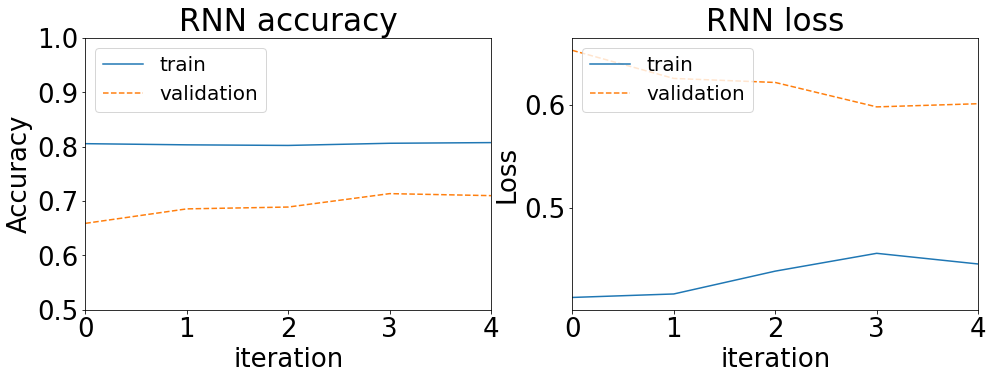

Participant  2


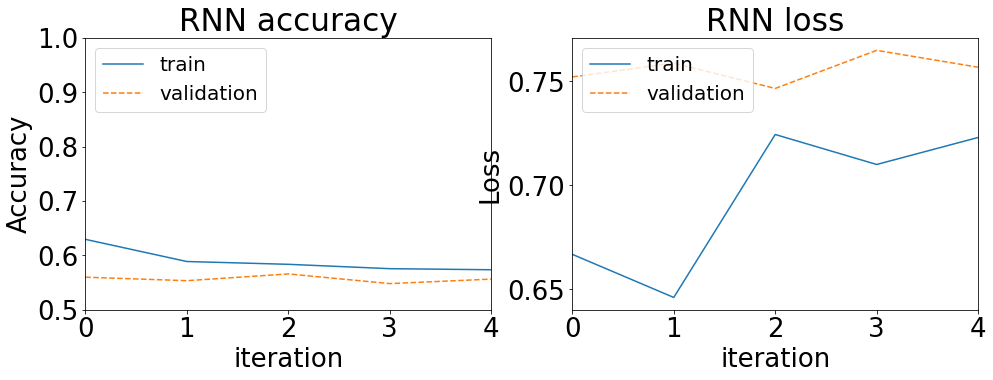

Participant  3


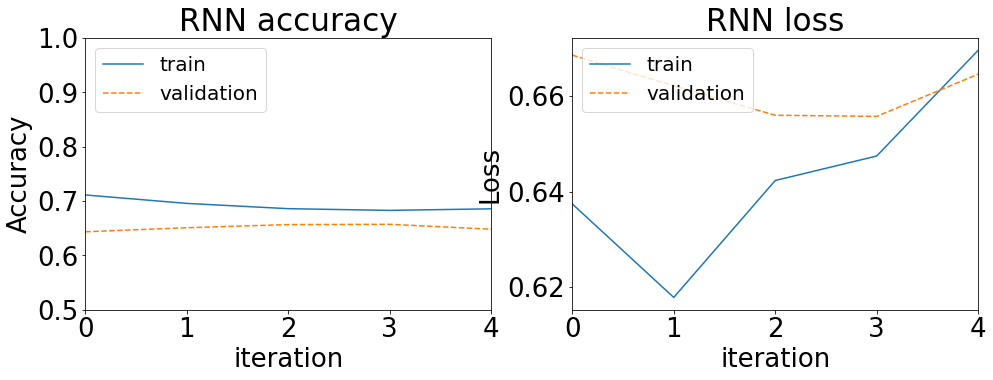

Participant  4


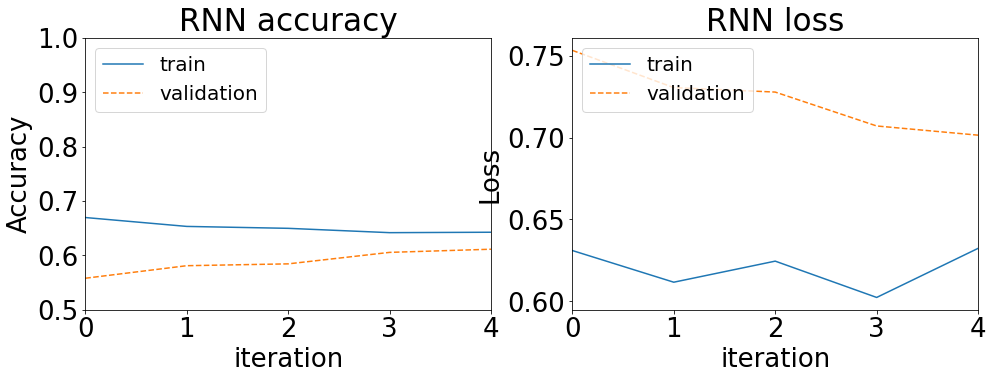

Participant  5


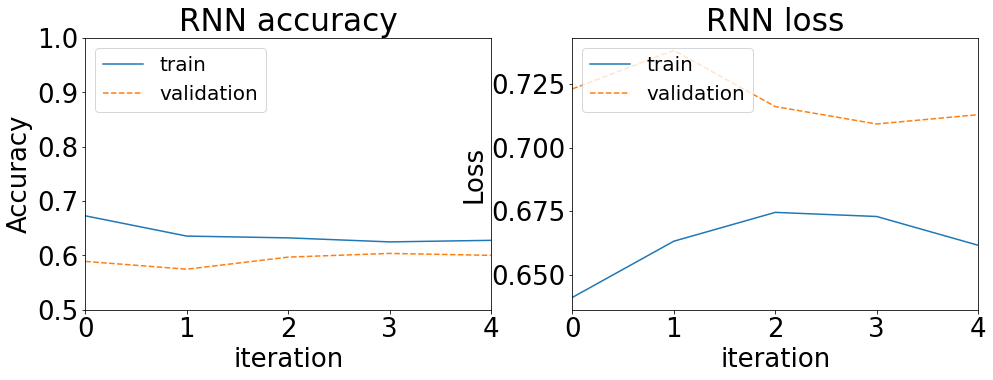

In [33]:
for par_histories in range(len(histories_participants)):
    par_history = histories_participants[par_histories]
    
    print('Participant ', par_histories+1)
    

    accuracy = par_history[0]
    val_accuracy = par_history[1]
    
    loss = par_history[2]
    val_loss = par_history[3]
    
#     print('accuracy: ', accuracy)
#     print('val_accuracy: ', val_accuracy)
    
    # summarize history for accuracy
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
    plt.rcParams['font.size']=26
    ax1.plot(accuracy)
    ax1.plot(val_accuracy, '--')
    ax1.set_title('RNN accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('iteration')
    plt.rcParams['font.size']=20
    ax1.legend(['train', 'validation'], loc='upper left')
    plt.rcParams['font.size']=26
    ax1.set_ylim([0.5, 1])
    ax1.set_xlim([0,4])

    ax2.plot(loss)
    ax2.plot(val_loss, '--')
    ax2.set_title('RNN loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('iteration')
    plt.rcParams['font.size']=20
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.rcParams['font.size']=26
    ax2.set_xlim([0,4])

    plt.savefig('RNN_training_{:d}.pdf'.format(par_histories), bbox_inches = 'tight')
    plt.show()
    
    

## LDA

In [ ]:
print(len(data_participants))
print(np.array([data_participants]).shape)

In [ ]:
# fit LDA + Epoch classification

def crossval_LDA(par, fold, Xtrain, Ytrain, Xtest, Ytest, sV, labels):
    clf = LDA()
    clf.fit(Xtrain, Ytrain)
    score = clf.score(Xtest, Ytest) * 100
    print('LDA participant {:d}, fold {:d}: epoch accuracy: {:.2f}%'.format(par+1, fold, score))
    
    
    trials = 20
    epochs = int(Xtest.shape[0]/trials)
    
    # Predict Xtrain epochs. Take column 1 since that equals probabilities of 1 occuring
    pred_proba = clf.predict_proba(Xtest)
    p1 = pred_proba[:,1]


    
    
    # Reshape predictions to trials x epochs
    predicted_trials = p1.reshape(trials,epochs)

    
    #First index of labels for the test set
    test_trials = 90

    
    predictions = np.zeros(trials)
    for i in range(trials):
        rho = np.corrcoef(predicted_trials[i,:],sV.T)[0, 1:]
        predictions[i]=np.argmax(rho)+1

    pp = sum(predictions == labels[:,0])
    trial_score = pp/trials*100
    print('LDA participant {:d}, fold {:d}: trial accuracy: {:.2f}%'.format(par+1, fold, trial_score))
    
    print('Predicted trials: ', predictions.astype(int))
    print('True trials:      ', labels[:,0], '\n')

In [ ]:
# par_data contains (list_fXtrain, list_fXtest, list_fYtrain, list_fYtest, list_labels)

for par_data in range(len(data_participants)): 
    for fold in range(n_folds):
        data_x_train = data_participants[par_data][0][fold]
        data_x_test = data_participants[par_data][1][fold]
        
        data_y_train = data_participants[par_data][2][fold]
        data_y_test = data_participants[par_data][3][fold]
        
        labels = data_participants[par_data][4][fold]
        

        s_train, w_train, c_train, s = data_x_train.shape
        s_test, w_test, c_test, s = data_x_test.shape
        
        Xtrain = data_x_train.reshape(s_train, w_train*c_train*s)
        Ytrain = data_y_train[:,1]
        
        Xtest = data_x_test.reshape(s_test, w_test*c_test*s) 
        Ytest = data_y_test[:,1]

        
        crossval_LDA(par_data, fold, Xtrain, Ytrain, Xtest, Ytest, sV, labels)

## NN

In [ ]:
# NN epoch + trial classification

def crossval_NN(par, fold, model, Xtrain, Ytrain, Xtest, Ytest, sV, labels):
    predict_proba_test = model.predict(data_x_test)
    true_epochs = data_y_test[:,1]
    pred_epochs = predict_proba_test[:,1]
    
    # Epoch classification
    correct = 0
    for i in range(true_epochs.shape[0]):
        if (pred_epochs[i] >= 0.5) and (true_epochs[i]==1):
            correct+=1
        if (pred_epochs[i] < 0.5) and (true_epochs[i]==0):
            correct+=1
    
    score = correct / true_epochs.shape[0]
    print('NN participant {:d}, fold {:d}: epoch accuracy: {:.2f}%'.format(par+1, fold, score))
    
    
    # Trial classification
    trials = 20
    epochs = int(Xtest.shape[0]/trials)

    predicted_trials = pred_epochs.reshape(trials,epochs)



    # Use correlation to match predicted pattern to specific label
    predictions = np.zeros(trials)
    for i in range(trials):
        rho = np.corrcoef(predicted_trials[i,:],sV.T)[0, 1:]
        predictions[i]=np.argmax(rho)+1

    pp = sum(predictions == labels[:,0])
    trial_score = pp/trials*100
    
    print('NN participant {:d}, fold {:d}: trial accuracy: {:.2f}%'.format(par+1, fold, trial_score))   
    print('Predicted trials: ', predictions.astype(int))
    print('True trials:      ', labels[:,0], '\n')


In [ ]:
# par_data contains (list_fXtrain, list_fXtest, list_fYtrain, list_fYtest, list_labels)

for par_data in range(len(data_participants)): 
    for fold in range(len(list_fXtrain)):
        
        # Load fold data
        data_x_train = data_participants[par_data][0][fold]
        data_x_test = data_participants[par_data][1][fold]
        
        data_y_train = data_participants[par_data][2][fold]
        data_y_test = data_participants[par_data][3][fold]
        
        labels = data_participants[par_data][4][fold]
        
        
        # Load fold model
        model = models_participants[par_data][fold]
        

        crossval_NN(par_data, fold, model, data_x_train, data_y_train, data_x_test, data_y_test, sV, labels)